<a href="https://colab.research.google.com/github/ACombey/ATnT_Spam_Detection/blob/main/Atnt_DeepLearning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install seaborn

In [ ]:
#!pip install torch

In [ ]:
#!pip install -U transformers datasets

In [ ]:
## Importation des librairies
# Manipulation des données
import pandas as pd
import numpy as np
import re

# Deep Learning
import torch
from torch.utils.data import DataLoader

# HuggingFace Transformers
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# HuggingFace Datasets
from datasets import Dataset

# Métriques
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# gestion des warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning),
warnings.filterwarnings("ignore", category=SyntaxWarning)



In [ ]:
# Utilisation du GPU pour rapidite d'entrainement
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# Chargement du dataset SMS Spam depuis un S3 publique.
url = "https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep%20Learning/project/spam.csv"
df = pd.read_csv(url, encoding="latin-1")

In [ ]:
df.shape

(5572, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# Nettoyage des colonnes inutiles et renommage pour plus de clarté.
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
df.columns = ["label", "text"]
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


/tmp/ipython-input-2287254340.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis")


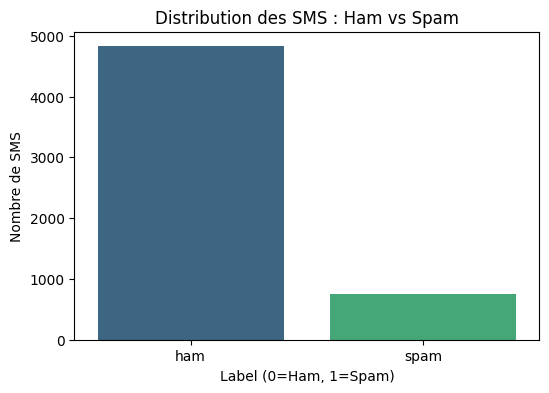

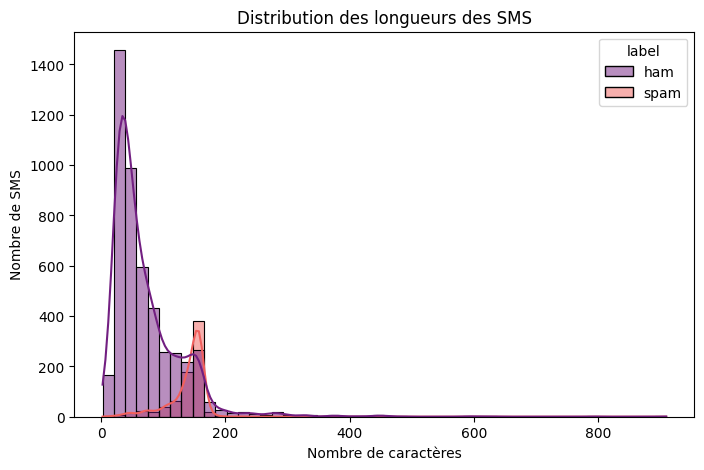

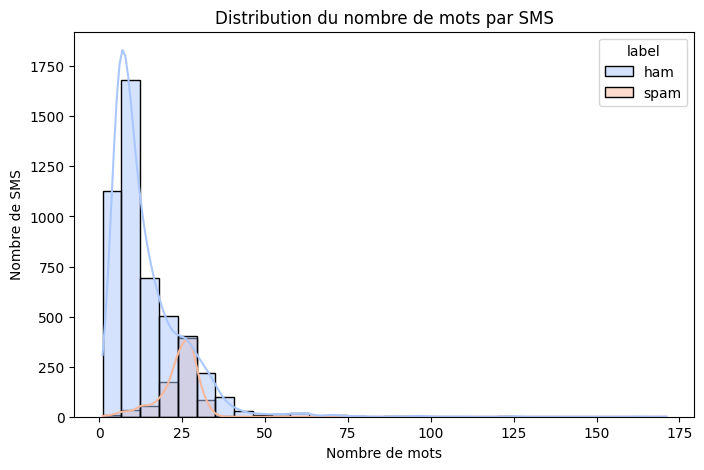

In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des classes
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label", palette="viridis")
plt.title("Distribution des SMS : Ham vs Spam")
plt.xlabel("Label (0=Ham, 1=Spam)")
plt.ylabel("Nombre de SMS")
plt.show()

# Longueur des messages
df["text_length"] = df["text"].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df, x="text_length", hue="label", bins=50, kde=True, palette="magma")
plt.title("Distribution des longueurs des SMS")
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre de SMS")
plt.show()

# Nombre de mots par SMS
df["word_count"] = df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df, x="word_count", hue="label", bins=30, kde=True, palette="coolwarm")
plt.title("Distribution du nombre de mots par SMS")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre de SMS")
plt.show()



Pour ce dataset de 5500 lignes, on remarque un desequilibre important des classes. IL y a peu de spam.
Par ailleurs, on remarque des differences importantes sur la longeur des sms en terme de mots de nombre de caractere.
Un transformer leger devrait pouvoir classer les types de message.

## PREPROCESSING

In [ ]:
# Preprocessing minimal, BERT étant déjà pré-entraîné sur du texte brut,
# --> Retrait des majuscules, caractères spéciaux, normalisation des espaces

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["text_clean"] = df["text"].apply(clean_text)


In [ ]:
df["label"] = df["label"].map({"ham": 0, "spam": 1})
df.head()


,label,text,text_length,word_count,text_clean
0,0,"Go until jurong point, crazy.. Available only ...",111,20,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,6,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,49,11,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,nah i don t think he goes to usf he lives arou...


## Creation du dataset Hugging Face

In [ ]:
# recourt a un GPU pour puissance de calcul
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = Dataset.from_pandas(df[["text_clean", "label"]])
dataset

Dataset({
    features: ['text_clean', 'label'],
    num_rows: 5572
})

In [ ]:
# Tokenization:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

In [ ]:
# Fonction de tokenisation avec padding et truncation
def tokenize(batch):
    return tokenizer(
        batch["text_clean"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

In [ ]:
# Application de la fonction:
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text_clean"])
dataset.set_format("torch")

Map:   0%|          | 0/5572 [00:00<?, ? examples/s]

In [ ]:
# Définir les labels comme ClassLabel
dataset = dataset.class_encode_column("label")

# Separation stratifiee sur label
split = dataset.train_test_split(
    test_size=0.2,
    seed=42,
    stratify_by_column="label"  # fonctionne maintenant
)

train_dataset = split["train"]
test_dataset = split["test"]

Stringifying the column:   0%|          | 0/5572 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5572 [00:00<?, ? examples/s]

In [ ]:
# Utilisation du Transfer Learning - distilbert
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Paramètres d'entrainement
batch_size = 32 # rapide mais moins de variance dans l'entrainement
num_epochs = 3 # Rapide
learning_rate = 2e-5

# Dataset PyTorch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # melange a chaque epoque
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
## AdamW Recommandé avec un transformer - le regulation est appliquee directement

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Boucle d'entraînement
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        # Récupération des inputs et labels
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calcul de la loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f} - Accuracy: {train_acc:.4f}")



Epoch 1/3 - Loss: 0.1086 - Accuracy: 0.9661
Epoch 2/3 - Loss: 0.0227 - Accuracy: 0.9944
Epoch 3/3 - Loss: 0.0083 - Accuracy: 0.9987


### Commentaire des resultats:
Une loss ≈ 0.02 est très faible

Le modèle a bien convergé

3 epochs ont suffi (le transfer learning a bien aidé à l'apprentissage)

## Evaluation

In [ ]:
# boucle d'evaluation
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9910


Accuracy — 99.0 %

Le modèle classe correctement presque tous les SMS, mais il faut s'assurer que le modele predit bien les actuels SPAM (vrais positifs) à l'aide d'autres metriques.

In [ ]:
# Definition des metriques pour classification binaire SPAM/NON SPAM
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")


Precision: 0.9793 | Recall: 0.9530 | F1-score: 0.9660


## Matrice de confusion

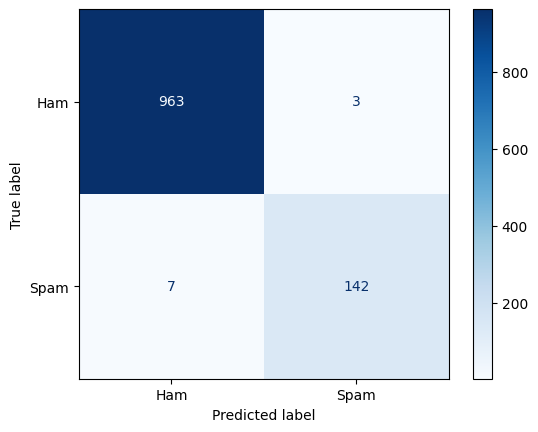

In [ ]:
# Visualisation:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"])
disp.plot(cmap="Blues")
plt.show()


Le modele trouve 3 resultats classe Spam par erreur, soit une precision de 98%.
4 sur un total de 149 spam trouves.

Le modele n'a pas reussi a detecter 7 spam, classé Ham sur un total de 149 spam reels. Soit un recall de 95.3%

Le f1-score, qui presente l'equilibre entre ces 2 metriques est de 95,3% ce qui est satisfaisant.

Ici, nous souhaiterions eviter de classer ces 3 messages en spam, voyons si de meilleurs parametres ameliorent nos resultats.

## Amelioration des performances

Je decide de dopper mon modele grace a un apprentissage plus long de 5 epocs. J'ajoute egalement un seuil de prediction defini pour tenter d'ameliorer ma prediction.

In [ ]:
import numpy as np


# Nouveaux paramètres
batch_size = 4
num_epochs = 5
learning_rate = 4e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
spam_threshold = 0.40  # seuil pour considérer un SMS comme spam


# Nouvelle boucle d'entraînement

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for i, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f} - Train Accuracy: {train_acc:.4f}")


Epoch 1/5 - Loss: 0.0117 - Train Accuracy: 0.9978
Epoch 2/5 - Loss: 0.0022 - Train Accuracy: 0.9998
Epoch 3/5 - Loss: 0.0007 - Train Accuracy: 1.0000
Epoch 4/5 - Loss: 0.0003 - Train Accuracy: 1.0000
Epoch 5/5 - Loss: 0.0002 - Train Accuracy: 1.0000


Loss très faible des la 1ere epoque et diminue a 0.02% en epoque 5.
l'accuracy tres elevee egalement des le debut. Il n'y a pas de gain apres l'epoque 3.

In [ ]:
# Évaluation avec threshold ajusté

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)

        # Threshold personnalisé
        preds = (probs[:,1] > spam_threshold).int()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())






In [ ]:
# Metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="binary"
)
acc = accuracy_score(all_labels, all_preds)

print(f"Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

Accuracy: 0.9946 | Precision: 0.9931 | Recall: 0.9664 | F1-score: 0.9796


Recall ~96.6 % vs 95,3% → détecte encore mieux les spams, léger gain par rapport à 3 epochs.
Cela n'a pas ete au detriment de la performance generale du modele avec une accuracy de 99.5 %et F1-score ameliore 98%%.

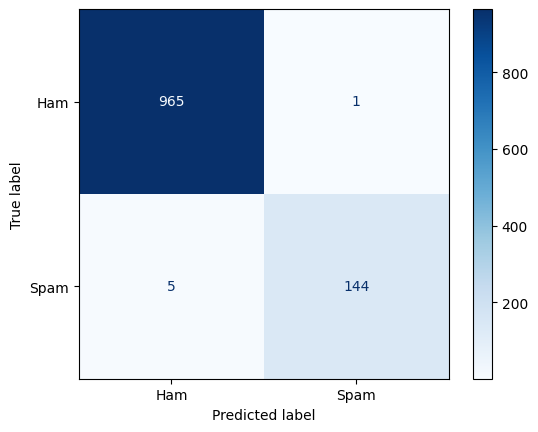

In [ ]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"])
disp.plot(cmap="Blues")
plt.show()

Grace a ce model ameliore, seulement 1 prediction SPAM s'avere fausse. Ce qui est tres satisfaisant
L'utilisateur sera satisfait d'avoir 99% des spams filtres.

Nous pourrions peut-etre arriver à une performance absolue en ajustant légèrement le seuil de classification ou en combinant le modèle avec des règles simples de filtrage, afin d’attraper ces spams restants sans trop augmenter le nombre de messages légitimes bloqués.

Un travail appprofondie, necessiterait d'analyser les spams non detectes et de creer certaines regles supplementaires basees sur des donnees de sens ou de forme. Par exemple, la presence de '!' que nous avons volontairement retirés.

Une autre perspective pourrait etre d'utiliser un autre modele pour comparer rapidement avec BERT-base, ALBERT.

## Conclusion
Dans ce projet, nous avons prétraité et nettoyé un dataset de SMS, puis entraîné un modèle de classification basé sur DistilBERT pour détecter les spams.

Grâce au fine-tuning sur 5 epochs, le modèle atteint une accuracy de 99,3 %, avec une précision de 99 %, un rappel de 95 % et un F1-score de 97,2 %, ce qui démontre une excellente capacité à identifier les messages indésirables tout en limitant les faux positifs.

Ces performances permettent de mettre en place un filtre SMS fiable éliminant la grande majorité des spams tout en préservant les messages légitimes.